<a href="https://colab.research.google.com/github/Kevin20250000000/Using-Monte-Carlo-Simulation-to-Predict-VaR/blob/main/Using_Variance_Covariance_Methord_%26_Monte_Carlo_Simulation_to_Manage_Risk_VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value at Risk (VaR)

 **Value at Risk (VaR)** is a widely used statistical measure in financial risk management that estimates the potential maximum loss of a portfolio or asset over a specified time frame, given a certain confidence level. It provides a probabilistic assessment of the worst-case scenario under normal market conditions.


**Key Components of VaR**

Time Horizon: The period over which the risk is assessed (e.g., one day, ten days, or one month).

Confidence Level: The probability that the loss will not exceed the VaR estimate (commonly 95% or 99%).

Potential Loss Amount: The estimated maximum loss in monetary terms or as a percentage of the portfolio's value.


##**Example**

Consider a portfolio with a one-day VaR of  1  million dollars at a 95% confidence level. This implies that there is a 95% chance that the portfolio will not lose more than $1 million in a single day, and a 5% chance that the loss could exceed this amount.


## **Calculation Methods**
**VaR can be calculated using several methods:**

### 1. Historical Simulation Method

For a given confidence level \( \alpha \) (e.g., 95% or 99%) and a historical dataset of returns, VaR can be estimated as:


$$\text{VaR}_{\alpha} = \text{Quantile}_{\alpha}(\text{Return Distribution})$$

where $(\text{Quantile}_{\alpha}$) is the value below which $( \alpha \% $) of the observations fall.

### 2. Variance-Covariance Method

In this method, assuming returns are normally distributed, VaR can be calculated using:

$[ \text{VaR}_{\alpha} = \mu - Z_{\alpha} \cdot \sigma $]

where:
- $(\mu$) = Mean of the portfolio returns
- $(\sigma$) = Standard deviation of the portfolio returns
- $(Z_{\alpha}$) = Z-score corresponding to the confidence level $( \alpha $) (e.g., 1.645 for 95% confidence)

### 3. Monte Carlo Simulation

VaR can also be estimated using Monte Carlo simulation by simulating a large number of portfolio returns and calculating the percentile value at the desired confidence level.



###**Limitations**

While VaR is a valuable tool for risk assessment, it has certain limitations:

Tail Risk Ignorance: VaR does not provide information about losses beyond the confidence level threshold, potentially underestimating extreme losses.

Assumption Sensitivity: The accuracy of VaR is highly dependent on the assumptions made regarding market behavior and return distributions.

Methodological Variance: Different calculation methods can yield varying VaR estimates for the same portfolio.

Despite these limitations, VaR remains a fundamental metric in financial risk management, aiding institutions in understanding and controlling potential losses.


## Conclusion

Value at Risk (VaR) is a fundamental tool in financial risk management, providing a standardized measure to estimate potential losses in investment portfolios over a specified time frame and confidence level. By quantifying the maximum expected loss under normal market conditions, VaR enables investors and institutions to make informed decisions, optimize portfolios, and implement effective risk mitigation strategies.

### Importing Libraries 📚

In [1]:
import pandas as pd
import random
import numpy as np
import os
import matplotlib. pyplot as plt
from scipy.stats import norm
import scipy
from tabulate import tabulate

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import scipy.stats
from typing import List, Tuple

### Configuration Class 📋

This cell defines a configuration class `config` with various constants and parameters used for the analysis and simulations.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
# file_path = '/content/drive/My Drive/SharedFolder/Var Data'

In [22]:
class config:
    # Path to the directory containing daily and intraday stock data
    file_path = '/content/drive/MyDrive/Var Data'

    # Path to the CSV file with NSE 500 sector information
    sector_file_path = '/content/NSE500_sector_list.csv'

    # Number of top stocks to consider in the portfolio
    N_TOP_STOCKS = 10

    # Confidence level for Value at Risk (VaR) calculations
    CONFIDENCE_LEVEL = 0.95

    # Industry sector to focus on
    SINGLE_INDUSTRY = 'Capital Goods'

    # Weights for the equally weighted portfolio
    WEIGHTS = [1/N_TOP_STOCKS]*N_TOP_STOCKS

    # Start and end dates for the analysis period
    START_DATE = '2022-01-01'
    END_DATE = '2023-12-31'

    # Number of days ahead for simulations
    T = 100

    # Initial portfolio value in INR
    INITIAL_PORTFOLIO = 1000000

    # Number of simulations to run
    SIMULATIONS = [50, 500, 1000]

### Creating Portfolios 📈

This cell defines a function `create_portfolios` to generate two portfolios of stocks based on industry selection criteria.

In [23]:
def create_portfolios(file_path: str, N_TOP_STOCKS: int, single_industry: str, seed: int = 42) -> Tuple[List[str], List[str]]:
    # Set the random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Load the CSV file
    df = pd.read_csv(file_path)

    # Check if there are enough unique industries for portfolio1
    if df['Industry'].nunique() < N_TOP_STOCKS:
        raise ValueError(f"Not enough unique industries to create a portfolio with {N_TOP_STOCKS} different industries.")

    # Check if the specified single industry exists in the dataset
    if single_industry not in df['Industry'].unique():
        raise ValueError(f"The specified industry '{single_industry}' does not exist in the dataset.")

    # Shuffle the dataframe to ensure random selection
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Create lists to store selected stocks
    portfolio1 = []
    portfolio2 = []
    industries_selected1 = set()

    # Iterate over the dataframe and select stocks for portfolio1 from different industries
    for _, row in df.iterrows():
        if len(portfolio1) < N_TOP_STOCKS and row['Industry'] not in industries_selected1:
            portfolio1.append(row['Symbol'])
            industries_selected1.add(row['Industry'])
        if len(portfolio1) == N_TOP_STOCKS:
            break

    # Filter the dataframe for the specified single industry
    single_industry_df = df[df['Industry'] == single_industry]

    # Check if there are enough stocks in the specified single industry for portfolio2
    if len(single_industry_df) < N_TOP_STOCKS:
        raise ValueError(f"Not enough stocks in the specified industry '{single_industry}' to create a portfolio with {N_TOP_STOCKS} stocks.")

    # Select stocks for portfolio2 from the specified single industry
    portfolio2 = single_industry_df['Symbol'].head(N_TOP_STOCKS).tolist()

    return portfolio1, portfolio2

# Example usage
sector_file_path = '/content/NSE500_sector_list.csv'
portfolio1, portfolio2 = create_portfolios(sector_file_path, config.N_TOP_STOCKS, config.SINGLE_INDUSTRY)
print("Portfolio 1:", portfolio1)
print("Portfolio 2:", portfolio2)

Portfolio 1: ['JUBLINGREA', 'BHARTIARTL', 'LTF', 'ERIS', 'CENTURYTEX', 'KPIL', 'RAYMOND', 'BDL', 'BRITANNIA', 'ZEEL']
Portfolio 2: ['BDL', 'MTARTECH', 'PRINCEPIPE', 'RATNAMANI', 'ABB', 'HAL', 'GRAPHITE', 'KSB', 'BEL', 'SUZLON']


## **Part I**  
## Variance-Covariance Method

Replicate the variance-covariance method with `N` stocks from NSE 500, take two examples from similar and different industries. Introduce weights in the portfolio. Remember, now we need to calculate the covariance between them. Change the weights arbitrarily and compare results.

Let's construct two equally-weighted portfolios:

Diversified Portfolio:

`['JUBLINGREA', 'BHARTIARTL', 'LTF', 'ERIS', 'CENTURYTEX', 'KPIL', 'RAYMOND', 'BDL', 'BRITANNIA', 'ZEEL']`


Capital Goods portfolio

`['BDL', 'MTARTECH', 'PRINCEPIPE', 'RATNAMANI', 'ABB', 'HAL', 'GRAPHITE', 'KSB', 'BEL', 'SUZLON']`

In [24]:
class DataLoader:
    def __init__(self, directory_path: str):
        self.directory_path = directory_path

    def load_data(self) -> dict:
        data_dict = {}
        for file_name in os.listdir(self.directory_path):
            if file_name.endswith('.xlsx'):
                stock_name = file_name.split('.')[0]
                file_path = os.path.join(self.directory_path, file_name)
                data = pd.read_excel(file_path, parse_dates=['date'], sheet_name='Day')
                data_dict[stock_name] = data
        return data_dict

In [25]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    data = data.set_index('date')
    return data

In [26]:
# import os

# print("Files in the data directory:")
# print(os.listdir(config.file_path))

In [27]:
data_loader = DataLoader(config.file_path)
data_dict = data_loader.load_data()

# Preprocess data
for stock, data in data_dict.items():
    data_dict[stock] = preprocess_data(data)

# Display a sample stock data
sample_stock = list(data_dict.keys())[0]
data_dict[sample_stock].head()

open     high       low     close  volume
date                                                     
2018-12-26  20800.00  20800.0  19644.00  20597.55   18652
2018-12-27  20930.00  20997.4  20150.00  20258.70    2164
2018-12-28  20499.95  21178.0  20330.85  20974.10    2030
2018-12-31  21298.10  21298.1  20750.00  20824.40    1088
2019-01-01  20854.95  20870.0  20625.00  20666.35     517

In [28]:
def get_portfolio_data(stocks: list[str], start: str, end: str, data_dict: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Gets portfolio asset daily returns for a given period"""

    # Convert start and end dates to pandas datetime
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    # Initialize an empty DataFrame to store the closing prices
    portfolio_data = pd.DataFrame()

    for stock in stocks:
        if stock in data_dict:
            # Select the data for the given date range
            stock_data = data_dict[stock]
            stock_data = stock_data.loc[start_date:end_date, 'close']
            # Rename the column to the stock symbol
            stock_data = stock_data.rename(stock)
            # Concatenate to the portfolio_data DataFrame
            portfolio_data = pd.concat([portfolio_data, stock_data], axis=1)
        else:
            print(f"Warning: Stock {stock} not found in data_dict")

    # Calculate daily returns
    returns = portfolio_data.pct_change().dropna()

    return returns

In [29]:
# Portfolio 1: asset returns
portfolio_returns_1 = get_portfolio_data(portfolio1, config.START_DATE, config.END_DATE, data_dict)

# Portfolio 2: asset returns
portfolio_returns_2 = get_portfolio_data(portfolio2, config.START_DATE, config.END_DATE, data_dict)

### Getting data and calculating daily returns for each of the assets in two portfolios.

**Returns for assets in portfolio 1:**

In [30]:
portfolio_returns_1.tail()

JUBLINGREA  BHARTIARTL       LTF      ERIS  CENTURYTEX  \
2023-12-22 00:00:00    0.015324    0.011913  0.008248  0.019922   -0.007668   
2023-12-26 00:00:00    0.005197    0.010409  0.001309  0.024839   -0.006751   
2023-12-27 00:00:00    0.018495    0.021353  0.019935  0.005453    0.007903   
2023-12-28 00:00:00   -0.008396    0.015178  0.039090 -0.004547   -0.007069   
2023-12-29 00:00:00    0.001477   -0.004341  0.017885  0.001651    0.000409   

                         KPIL   RAYMOND       BDL  BRITANNIA      ZEEL  
2023-12-22 00:00:00  0.000000  0.005281  0.019465   0.020061  0.020404  
2023-12-26 00:00:00  0.014973 -0.003541  0.078666   0.014503 -0.011774  
2023-12-27 00:00:00  0.013347  0.007951  0.041480  -0.003657  0.006430  
2023-12-28 00:00:00  0.013017 -0.015603 -0.038241   0.012498  0.019542  
2023-12-29 00:00:00  0.078467  0.011565  0.008718   0.010687  0.012532

In [31]:
portfolio_returns_1.describe()

JUBLINGREA  BHARTIARTL         LTF        ERIS  CENTURYTEX        KPIL  \
count  493.000000  493.000000  493.000000  493.000000  493.000000  493.000000   
mean    -0.000023    0.000896    0.001756    0.000464    0.000828    0.001469   
std      0.023647    0.012894    0.023065    0.014828    0.022314    0.018978   
min     -0.084919   -0.049773   -0.106810   -0.062339   -0.079127   -0.065047   
25%     -0.013220   -0.006206   -0.010862   -0.008987   -0.012048   -0.010133   
50%     -0.002139    0.000355    0.001256   -0.000141   -0.001236    0.000358   
75%      0.011249    0.008587    0.014280    0.010085    0.012318    0.011939   
max      0.101678    0.046100    0.161784    0.056105    0.086881    0.078467   

          RAYMOND         BDL   BRITANNIA        ZEEL  
count  493.000000  493.000000  493.000000  493.000000  
mean     0.002602    0.003402    0.000872    0.000014  
std      0.032361    0.028731    0.012886    0.026454  
min     -0.100000   -0.113897   -0.064633   -0.079101  
25%     -0.015035   -0.012183   -0.006201   -0.015103  
50%      0.000940    0.000534    0.000809   -0.001080  
75%      0.016224    0.015396    0.007191    0.010168  
max      0.193168    0.160988    0.088074    0.167350

In [32]:
def plot_histograms_with_normal_dist(portfolio_returns: pd.DataFrame, portfolio: list, title: str):
    fig = make_subplots(
        rows=len(portfolio), cols=1, shared_xaxes=True,
        subplot_titles=[f"Daily returns for {ticker}" for ticker in portfolio]
    )

    for i, ticker in enumerate(portfolio):
        # Histogram of returns
        fig.add_trace(
            go.Histogram(
                x=portfolio_returns[ticker],
                nbinsx=40,
                histnorm='probability density',
                name=ticker,
                opacity=0.5,
                marker=dict(color='blue')
            ),
            row=i + 1, col=1
        )

        # Standard normal for stock returns
        mean = portfolio_returns[ticker].mean()
        std_dev = portfolio_returns[ticker].std()
        x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
        y = scipy.stats.norm.pdf(x, mean, std_dev)
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode='lines',
                line=dict(color='red'),
                name=f'{ticker} Normal Dist'
            ),
            row=i + 1, col=1
        )

    # Update layout
    fig.update_layout(
        height=1000,
        title_text=title,
        showlegend=False
    )

    fig.show()


In [33]:
#usage
plot_histograms_with_normal_dist(portfolio_returns_1, portfolio1, "Portfolio 1: Histogram of Returns (Overview of Return Distribution)")

**Returns for assets in portfolio 2:**

In [34]:
portfolio_returns_2.tail()

BDL  MTARTECH  PRINCEPIPE  RATNAMANI       ABB  \
2023-12-22 00:00:00  0.019465 -0.000938    0.011706   0.025359  0.015904   
2023-12-26 00:00:00  0.078666 -0.027742    0.005309  -0.004396  0.002595   
2023-12-27 00:00:00  0.041480 -0.017865   -0.008869  -0.008948 -0.007912   
2023-12-28 00:00:00 -0.038241  0.030434    0.010315   0.000929 -0.019150   
2023-12-29 00:00:00  0.008718  0.003431    0.004395  -0.008578  0.006871   

                          HAL  GRAPHITE       KSB       BEL    SUZLON  
2023-12-22 00:00:00 -0.001035  0.017190  0.008313  0.024319  0.004043  
2023-12-26 00:00:00  0.043256  0.035792 -0.008086  0.040904 -0.009396  
2023-12-27 00:00:00 -0.004414  0.009716 -0.003996 -0.009618  0.004065  
2023-12-28 00:00:00 -0.000855  0.002905  0.019024  0.013873  0.029690  
2023-12-29 00:00:00 -0.000642 -0.003983 -0.007359  0.008210  0.001311

In [35]:
portfolio_returns_2.describe()

BDL    MTARTECH  PRINCEPIPE   RATNAMANI         ABB         HAL  \
count  493.000000  493.000000  493.000000  493.000000  493.000000  493.000000   
mean     0.003402    0.000041    0.000286    0.002173    0.001707    0.003277   
std      0.028731    0.022462    0.018335    0.020651    0.019148    0.020142   
min     -0.113897   -0.114361   -0.069923   -0.059648   -0.073204   -0.091589   
25%     -0.012183   -0.010324   -0.008711   -0.009043   -0.007281   -0.007948   
50%      0.000534   -0.000532   -0.001041    0.000191    0.001861    0.001666   
75%      0.015396    0.010417    0.007421    0.010221    0.011172    0.012818   
max      0.160988    0.106173    0.152591    0.120338    0.102584    0.081059   

         GRAPHITE         KSB         BEL      SUZLON  
count  493.000000  493.000000  493.000000  493.000000  
mean     0.000442    0.002341    0.002123    0.003496  
std      0.023757    0.022562    0.018514    0.038808  
min     -0.098083   -0.061415   -0.072909   -0.113043  
25%     -0.012556   -0.009889   -0.008754   -0.018519  
50%     -0.001180    0.001072    0.000713    0.000000  
75%      0.010915    0.010611    0.012071    0.022876  
max      0.118909    0.180612    0.067454    0.197531

In [36]:
plot_histograms_with_normal_dist(portfolio_returns_2, portfolio2, "Portfolio 2: Histogram of Returns (Overview of Return Distribution)")

Visual inspection of stock return histograms reveals deviations from normality. Significant deviations suggest non-normality. The variance-covariance method for calculating Value at Risk (VaR) assumes that asset returns are normally distributed, implying that the portfolio return distribution is also normal. This assumption may not hold for real-world data, potentially leading to inaccurate risk assessments. Alternative methods, such as historical simulation or Monte Carlo simulations, do not rely on the normality assumption and can provide more robust risk estimates.

**Calculating VAR:**

We'll calculate 99%, 95% and 90% VAR for those two portfolios based on variance-covariance method. For that we need to estimate portfolio's:

- Expected return (mean)
- Volatility (standard deviation)

In [37]:
# Covariance matrix for assets in portfolio 1
cov_matrix_1 = portfolio_returns_1.cov()
cov_matrix_1

JUBLINGREA  BHARTIARTL       LTF      ERIS  CENTURYTEX      KPIL  \
JUBLINGREA    0.000559    0.000070  0.000198  0.000053    0.000165  0.000061   
BHARTIARTL    0.000070    0.000166  0.000093  0.000038    0.000071  0.000028   
LTF           0.000198    0.000093  0.000532  0.000087    0.000183  0.000064   
ERIS          0.000053    0.000038  0.000087  0.000220    0.000064  0.000016   
CENTURYTEX    0.000165    0.000071  0.000183  0.000064    0.000498  0.000056   
KPIL          0.000061    0.000028  0.000064  0.000016    0.000056  0.000360   
RAYMOND       0.000199    0.000076  0.000246  0.000082    0.000259  0.000029   
BDL           0.000218    0.000042  0.000157  0.000051    0.000152  0.000070   
BRITANNIA     0.000065    0.000031  0.000048  0.000020    0.000062  0.000003   
ZEEL          0.000160    0.000073  0.000163  0.000046    0.000164  0.000077   

             RAYMOND       BDL  BRITANNIA      ZEEL  
JUBLINGREA  0.000199  0.000218   0.000065  0.000160  
BHARTIARTL  0.000076  0.000042   0.000031  0.000073  
LTF         0.000246  0.000157   0.000048  0.000163  
ERIS        0.000082  0.000051   0.000020  0.000046  
CENTURYTEX  0.000259  0.000152   0.000062  0.000164  
KPIL        0.000029  0.000070   0.000003  0.000077  
RAYMOND     0.001047  0.000268   0.000044  0.000185  
BDL         0.000268  0.000825   0.000038  0.000138  
BRITANNIA   0.000044  0.000038   0.000166  0.000049  
ZEEL        0.000185  0.000138   0.000049  0.000700

In [38]:
# Covariance matrix for assets in portfolio 2
cov_matrix_2 = portfolio_returns_2.cov()
cov_matrix_2

BDL  MTARTECH  PRINCEPIPE  RATNAMANI       ABB       HAL  \
BDL         0.000825  0.000137    0.000098   0.000039  0.000110  0.000319   
MTARTECH    0.000137  0.000505    0.000119   0.000053  0.000073  0.000130   
PRINCEPIPE  0.000098  0.000119    0.000336   0.000046  0.000061  0.000093   
RATNAMANI   0.000039  0.000053    0.000046   0.000426  0.000042  0.000058   
ABB         0.000110  0.000073    0.000061   0.000042  0.000367  0.000104   
HAL         0.000319  0.000130    0.000093   0.000058  0.000104  0.000406   
GRAPHITE    0.000160  0.000183    0.000122   0.000100  0.000089  0.000144   
KSB         0.000049  0.000080    0.000033   0.000032  0.000038  0.000075   
BEL         0.000255  0.000162    0.000093   0.000058  0.000123  0.000210   
SUZLON      0.000280  0.000203    0.000143   0.000030  0.000140  0.000219   

            GRAPHITE       KSB       BEL    SUZLON  
BDL         0.000160  0.000049  0.000255  0.000280  
MTARTECH    0.000183  0.000080  0.000162  0.000203  
PRINCEPIPE  0.000122  0.000033  0.000093  0.000143  
RATNAMANI   0.000100  0.000032  0.000058  0.000030  
ABB         0.000089  0.000038  0.000123  0.000140  
HAL         0.000144  0.000075  0.000210  0.000219  
GRAPHITE    0.000564  0.000090  0.000163  0.000212  
KSB         0.000090  0.000509  0.000077  0.000067  
BEL         0.000163  0.000077  0.000343  0.000225  
SUZLON      0.000212  0.000067  0.000225  0.001506

In [39]:
portfolio_returns_1.mean()

JUBLINGREA   -0.000023
BHARTIARTL    0.000896
LTF           0.001756
ERIS          0.000464
CENTURYTEX    0.000828
KPIL          0.001469
RAYMOND       0.002602
BDL           0.003402
BRITANNIA     0.000872
ZEEL          0.000014
dtype: float64

In [40]:
# Expected daily return for portfolio 1
portfolio_mean_1 = portfolio_returns_1.mean().dot(config.WEIGHTS)
print(f"Expected daily return for portfolio 1: {np.round(portfolio_mean_1*100, 4)} %")

Expected daily return for portfolio 1: 0.1228 %


In [41]:
portfolio_returns_2.mean()

BDL           0.003402
MTARTECH      0.000041
PRINCEPIPE    0.000286
RATNAMANI     0.002173
ABB           0.001707
HAL           0.003277
GRAPHITE      0.000442
KSB           0.002341
BEL           0.002123
SUZLON        0.003496
dtype: float64

In [42]:
# Expected daily return for portfolio 2
portfolio_mean_2 = portfolio_returns_2.mean().dot(config.WEIGHTS)
print(f"Expected daily return for portfolio 2: {np.round(portfolio_mean_2*100, 4)} %")

Expected daily return for portfolio 2: 0.1929 %


In [43]:

# Volatility for portfolio 1
weights = np.array(config.WEIGHTS)
portfolio_sigma_1 = np.sqrt(weights.T.dot(cov_matrix_1).dot(weights))
print(f"Returns volatility for portfolio 1: {np.round(portfolio_sigma_1*100,4)}%")

Returns volatility for portfolio 1: 1.1832%


In [44]:

# Volatility for portfolio 2
weights = np.array(config.WEIGHTS)
portfolio_sigma_2 = np.sqrt(weights.T.dot(cov_matrix_2).dot(weights))
print(f"Returns volatility for portfolio 2: {np.round(portfolio_sigma_2*100,4)}%")


Returns volatility for portfolio 2: 1.2828%


In [45]:
# VAR for portfolio 1
VaR_90 = norm.ppf(1-0.9, portfolio_mean_1, portfolio_sigma_1)
VaR_95 = norm.ppf(1-0.95, portfolio_mean_1, portfolio_sigma_1)
VaR_99 = norm.ppf(1-0.99, portfolio_mean_1, portfolio_sigma_1)
print(tabulate([['90%', VaR_90], ['95%', VaR_95], ["99%", VaR_99]], headers=['Confidence Level', 'Value at Risk']))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0139352
95%                      -0.0182337
99%                      -0.0262971


For calculated VAR for portfolio 1, we can expect that the following day, losses won't be greater than:

- `1.39%` with a confidence of `90%` (10 % change of loss being greater than 1.39%)
- `1.82%` witha a confidence of `95%` (5 % change of loss being greater than 1.82%)
- `2.62%` witha a confidence of `99%` (1 % change of loss being greater than 2.62%)

In [46]:
# VAR for portfolio 2
VaR_90 = norm.ppf(1-0.9, portfolio_mean_2, portfolio_sigma_2)
VaR_95 = norm.ppf(1-0.95, portfolio_mean_2, portfolio_sigma_2)
VaR_99 = norm.ppf(1-0.99, portfolio_mean_2, portfolio_sigma_2)
print (tabulate([['90%', VaR_90], ['95%', VaR_95], ["99%", VaR_99]], headers=['Confidence Level', 'Value at Risk']))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0145106
95%                      -0.019171
99%                      -0.027913


Based on the calculated Value at Risk (VaR) metrics for Portfolio 2, we observe the following potential losses for the next trading day:

1.45% loss with a 90% confidence level (10% chance of exceeding this loss)

1.91% loss with a 95% confidence level (5% chance of exceeding this loss)

2.79% loss with a 99% confidence level (1% chance of exceeding this loss)

These figures indicate that Portfolio 2, focused on Capital Goods, carries a higher risk compared to Portfolio 1, which comprises stocks from various industries.


Now let's test different portfolio allocations and see which one has the best VAR measure (we could further do portfolio optimisation based on VAR level)

In [47]:
def var_varriance_covariance(returns, weights):
    """Calculates VAR using variance-covariance method."""

    # Calculated portfolio mean and signa (assuming normal return distribution)
    cov_matrix = returns.cov()
    mean = returns.mean().dot(weights)
    sigma = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

    VaR_90 = norm.ppf(1-0.9, mean, sigma)
    VaR_95 = norm.ppf(1-0.95, mean, sigma)
    VaR_99 = norm.ppf(1-0.99, mean, sigma)
    print(tabulate([['90%', VaR_90], ['95%', VaR_95], ["99%", VaR_99]], headers=['Confidence Level', 'Value at Risk']))

**Portfolio 1:**

In [48]:
var_varriance_covariance(portfolio_returns_1, np.array([0.10, 0.25, 0.05, 0.05, 0.06, 0.01, 0.08, 0.10, 0.10, 0.20])) # first

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0145309
95%                      -0.0189438
99%                      -0.0272216


In [49]:
var_varriance_covariance(portfolio_returns_1, np.array([0.20, 0.05, 0.25, 0.05, 0.06, 0.01, 0.08, 0.10, 0.10, 0.10])) # second

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0167351
95%                      -0.0218206
99%                      -0.03136


In [50]:
var_varriance_covariance(portfolio_returns_1, np.array([0.10, 0.05, 0.25, 0.15, 0.05, 0.02, 0.08, 0.05, 0.15, 0.10])) # thrid one

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0147712
95%                      -0.0192797
99%                      -0.0277368


We can see that for a few portfolio allocations we have that the best risk measure has the third one: first one.

**Portfolio 2:**

In [51]:
var_varriance_covariance(portfolio_returns_2, np.array([0.10, 0.25, 0.05, 0.05, 0.06, 0.01, 0.08, 0.10, 0.10, 0.20])) # first

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0177582
95%                      -0.0232997
99%                      -0.0336946


In [52]:
var_varriance_covariance(portfolio_returns_2, np.array([0.20, 0.05, 0.25, 0.05, 0.06, 0.01, 0.08, 0.10, 0.10, 0.10])) # second

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0156041
95%                      -0.0205462
99%                      -0.0298168


In [53]:
var_varriance_covariance(portfolio_returns_2, np.array([0.10, 0.05, 0.25, 0.15, 0.05, 0.02, 0.08, 0.05, 0.15, 0.10])) # third

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.014623
95%                      -0.0192534
99%                      -0.0279395


In all the additional allocation we test out, it seems that the portfolio 2 is riskier than the portfolio 1.



## **Part II**
##Monte Carlo Method

Construct a portfolio A with `N` value stocks with predefined weigts and portfolio B with hyped stocks.

Calculate 95% VaR for A and B using MCM and python and compare them over different number of simulations.

First, let's start with construction our two portfolios.

Some of the characteristics of the value stocks are that they are:

usually mature businesses.
have a steady (but not spectacular) growth rates.
have a relatively stable revenues and earnings.
usually paying dividends.
The general idea for value investing is to find companies trading at a discount to their intrinsic value, with the expectation that they'll be likely to outperform the overall stock market over time.

For the portfolio A we'll chose the following three stocks:

TCS

ITC

COALINDIA

For the portfolio B, consistent of the hyped assets, we'll chose some stokcs from sunrise industry:

CGPOWER

DIXON

RAYMOND

In [54]:
# Portfolio A (value stocks)
stocks_a = ["TCS", "ITC", "COALINDIA"]

# Portfolio B (cryptocurrencies)
stocks_b = ["CGPOWER", "DIXON", "RAYMOND"]

# Weights for equally weighted portfolio
weights = [1/3]*3


In [55]:
# Portfolio 1: asset returns
asset_returns_a = get_portfolio_data(stocks_a, config.START_DATE, config.END_DATE, data_dict)

# Portfolio 2: asset returns
asset_returns_b = get_portfolio_data(stocks_b, config.START_DATE, config.END_DATE, data_dict)

Daily returns of portfolio assets:

1. Portfolio A: daily returns for portfolio assets

In [56]:
asset_returns_a.tail()

TCS       ITC  COALINDIA
2023-12-22 00:00:00  0.009637  0.008307   0.021800
2023-12-26 00:00:00 -0.007440  0.002746   0.007708
2023-12-27 00:00:00  0.004123  0.001424  -0.001229
2023-12-28 00:00:00 -0.002965  0.015314   0.041986
2023-12-29 00:00:00 -0.001711 -0.004309  -0.012994

In [57]:
asset_returns_a.describe()

TCS         ITC   COALINDIA
count  493.000000  493.000000  493.000000
mean     0.000074    0.001590    0.002209
std      0.013190    0.012298    0.020253
min     -0.054178   -0.055926   -0.077473
25%     -0.006813   -0.005698   -0.007634
50%     -0.000028    0.001474    0.001337
75%      0.007391    0.008669    0.012056
max      0.052833    0.047593    0.099814

2. Portfolio B: daily returns for portfolio assets

In [58]:
asset_returns_b.tail()

CGPOWER     DIXON   RAYMOND
2023-12-22 00:00:00  0.023241 -0.006639  0.005281
2023-12-26 00:00:00 -0.003000 -0.003435 -0.003541
2023-12-27 00:00:00 -0.015366  0.001216  0.007951
2023-12-28 00:00:00 -0.012660  0.000093 -0.015603
2023-12-29 00:00:00  0.004532  0.015809  0.011565

In [59]:
asset_returns_b.describe()

CGPOWER       DIXON     RAYMOND
count  493.000000  493.000000  493.000000
mean     0.001947    0.000628    0.002602
std      0.022265    0.023279    0.032361
min     -0.067673   -0.190856   -0.100000
25%     -0.011298   -0.010398   -0.015035
50%      0.000365    0.000302    0.000940
75%      0.013058    0.011166    0.016224
max      0.199923    0.111921    0.193168

Now let's calcualte 95% VAR using Monte Carlo method over different simulation and see which of two constructed porfolios is risker based on the VAR metric.

In [60]:
def var_mcm(returns: pd.Series, alpha:int = 5) -> str:
    """Calculates VAR using Monte Carlo simulations"""

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

In [61]:
def simulate_portfolio(returns: pd.DataFrame, weights: List[float], num_of_sim:int = 400, T:int = 100, initial_portfolio:int = 1000000):

    # Portfolio assets' expected returns and cov. matrix
    returns_mean = returns.mean()
    cov_matrix = returns.cov()

    # Placeholder matrix for asset returs
    mean = np.full(shape=(T, len(weights)), fill_value=returns_mean)
    mean = mean.T

    # Placeholder for portfolio mtm value simulation
    # T days ahead over num_of_sim simulations
    portfolio_sims = np.full(shape=(T, num_of_sim), fill_value=0.0)

    # Simulate portfolio movement
    for m in range(0, num_of_sim):
        Z = np.random.normal(size=(T, len(weights)))
        L = np.linalg.cholesky(cov_matrix)
        daily_returns = mean + np.inner(L, Z)
        portfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio

    return portfolio_sims

1. Portfolio A: 95% VAR using MCM

In [62]:

# Simulating portfolio evolution
portfolio_a_simulations = []
for num_of_sim in config.SIMULATIONS:
    portfolio_a_simulations.append(simulate_portfolio(
                                      returns=asset_returns_a,
                                      weights=weights,
                                      num_of_sim=num_of_sim,
                                      T=config.T,
                                      initial_portfolio=config.INITIAL_PORTFOLIO
                                  ))


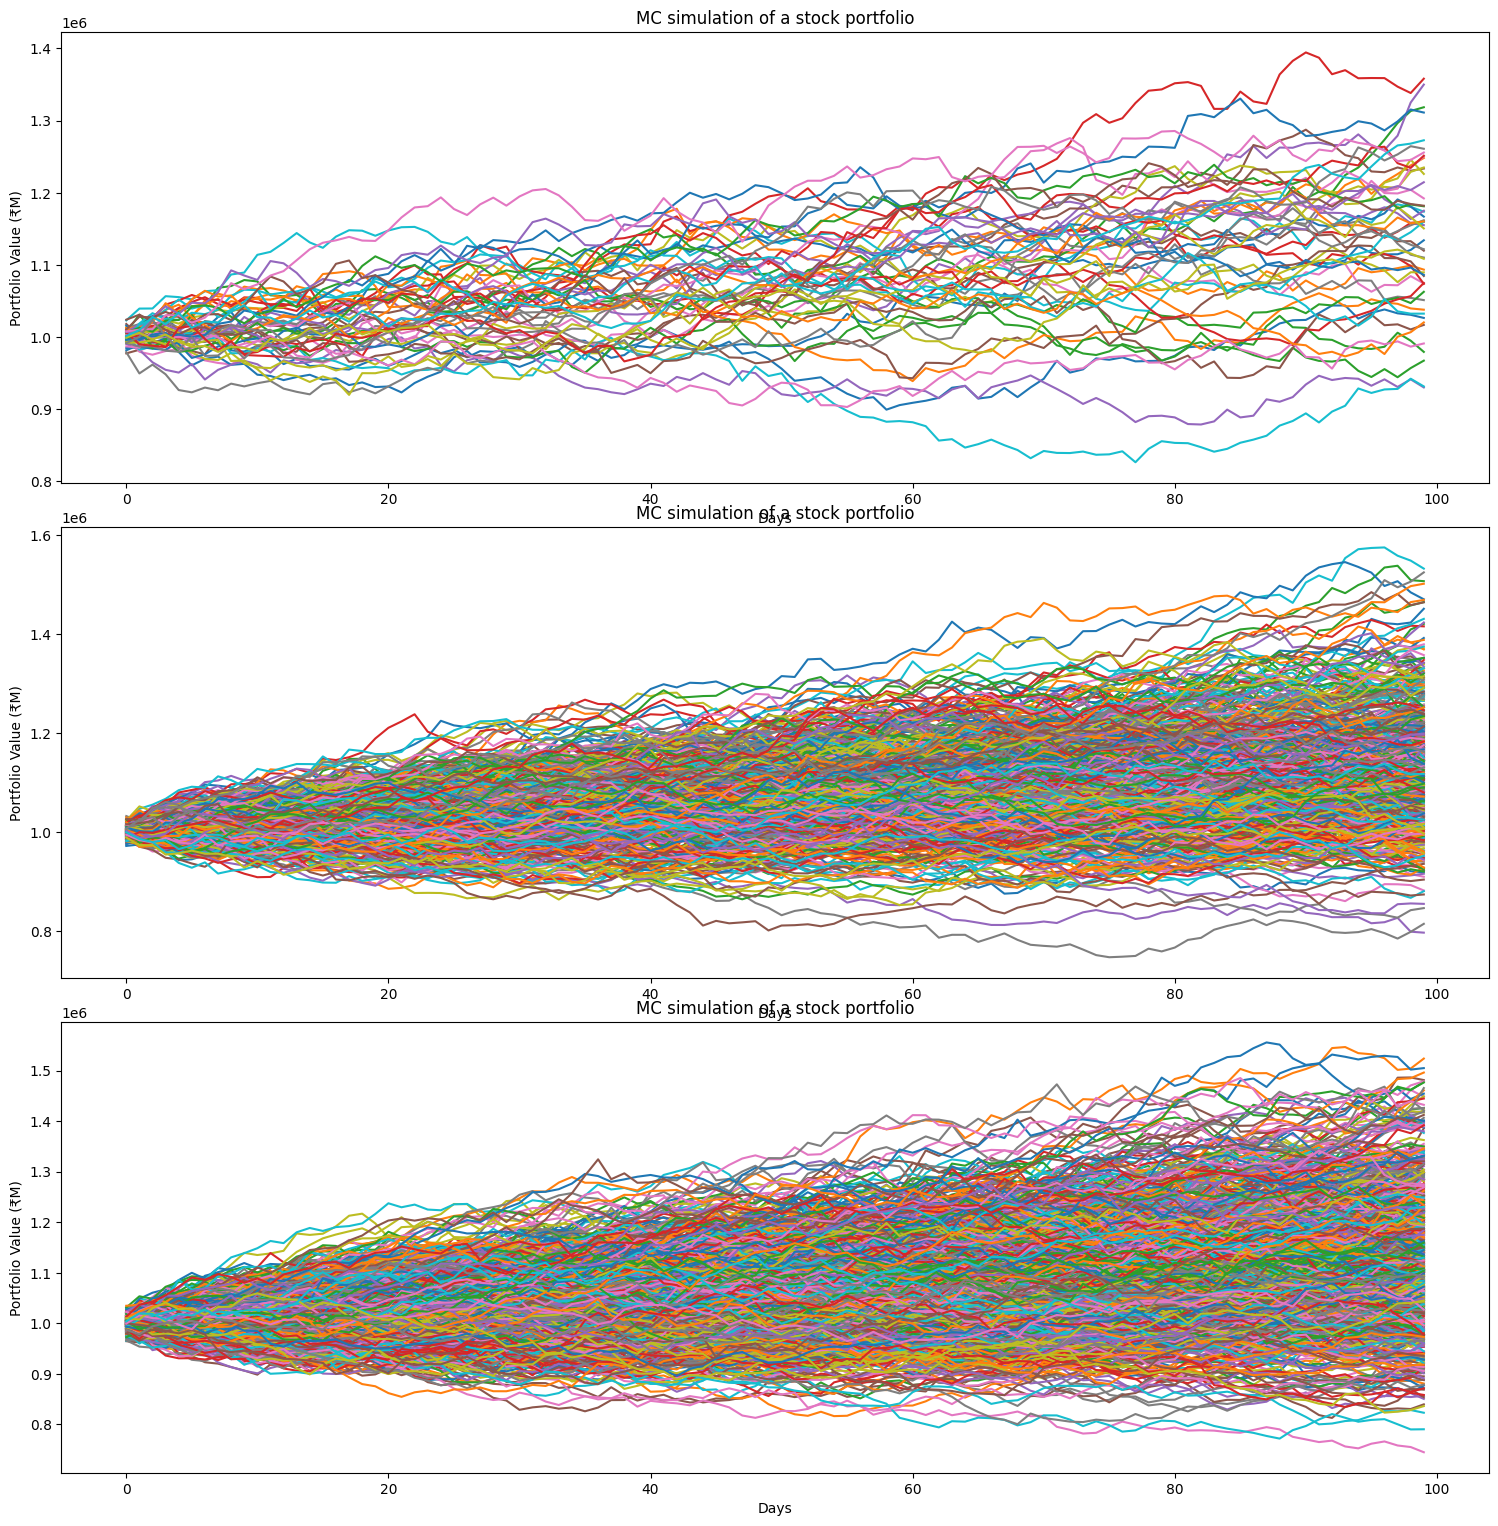

In [63]:

# Ploting portfolio simulation
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
fig.tight_layout()

for i, sim in enumerate(portfolio_a_simulations):
    # New subplot for each portfolio simulation
    plt.subplot(3, 1, i + 1,)

    plt.plot(sim)
    plt.ylabel('Portfolio Value (₹M)')
    plt.xlabel('Days')
    plt.title('MC simulation of a stock portfolio')

In [64]:
# Calculating portfolio VAR

for i, sim in enumerate(portfolio_a_simulations):
    portfolio_last_values = pd.Series(sim[-1,:])

    VaR = (config.INITIAL_PORTFOLIO - var_mcm(portfolio_last_values, alpha=5))

    print(f'95% VaR with {config.SIMULATIONS[i]} simulations: ₹{round(VaR,2)}')

95% VaR with 50 simulations: ₹27424.02
95% VaR with 500 simulations: ₹48583.0
95% VaR with 1000 simulations: ₹57958.59


2. Portfolio B: 95% VAR using MCM

In [65]:
# Simulating portfolio evolution
portfolio_b_simulations = []
for num_of_sim in config.SIMULATIONS:
    portfolio_b_simulations.append(simulate_portfolio(
                                      returns=asset_returns_b,
                                      weights=weights,
                                      num_of_sim=num_of_sim,
                                      T=config.T,
                                      initial_portfolio=config.INITIAL_PORTFOLIO
                                  ))

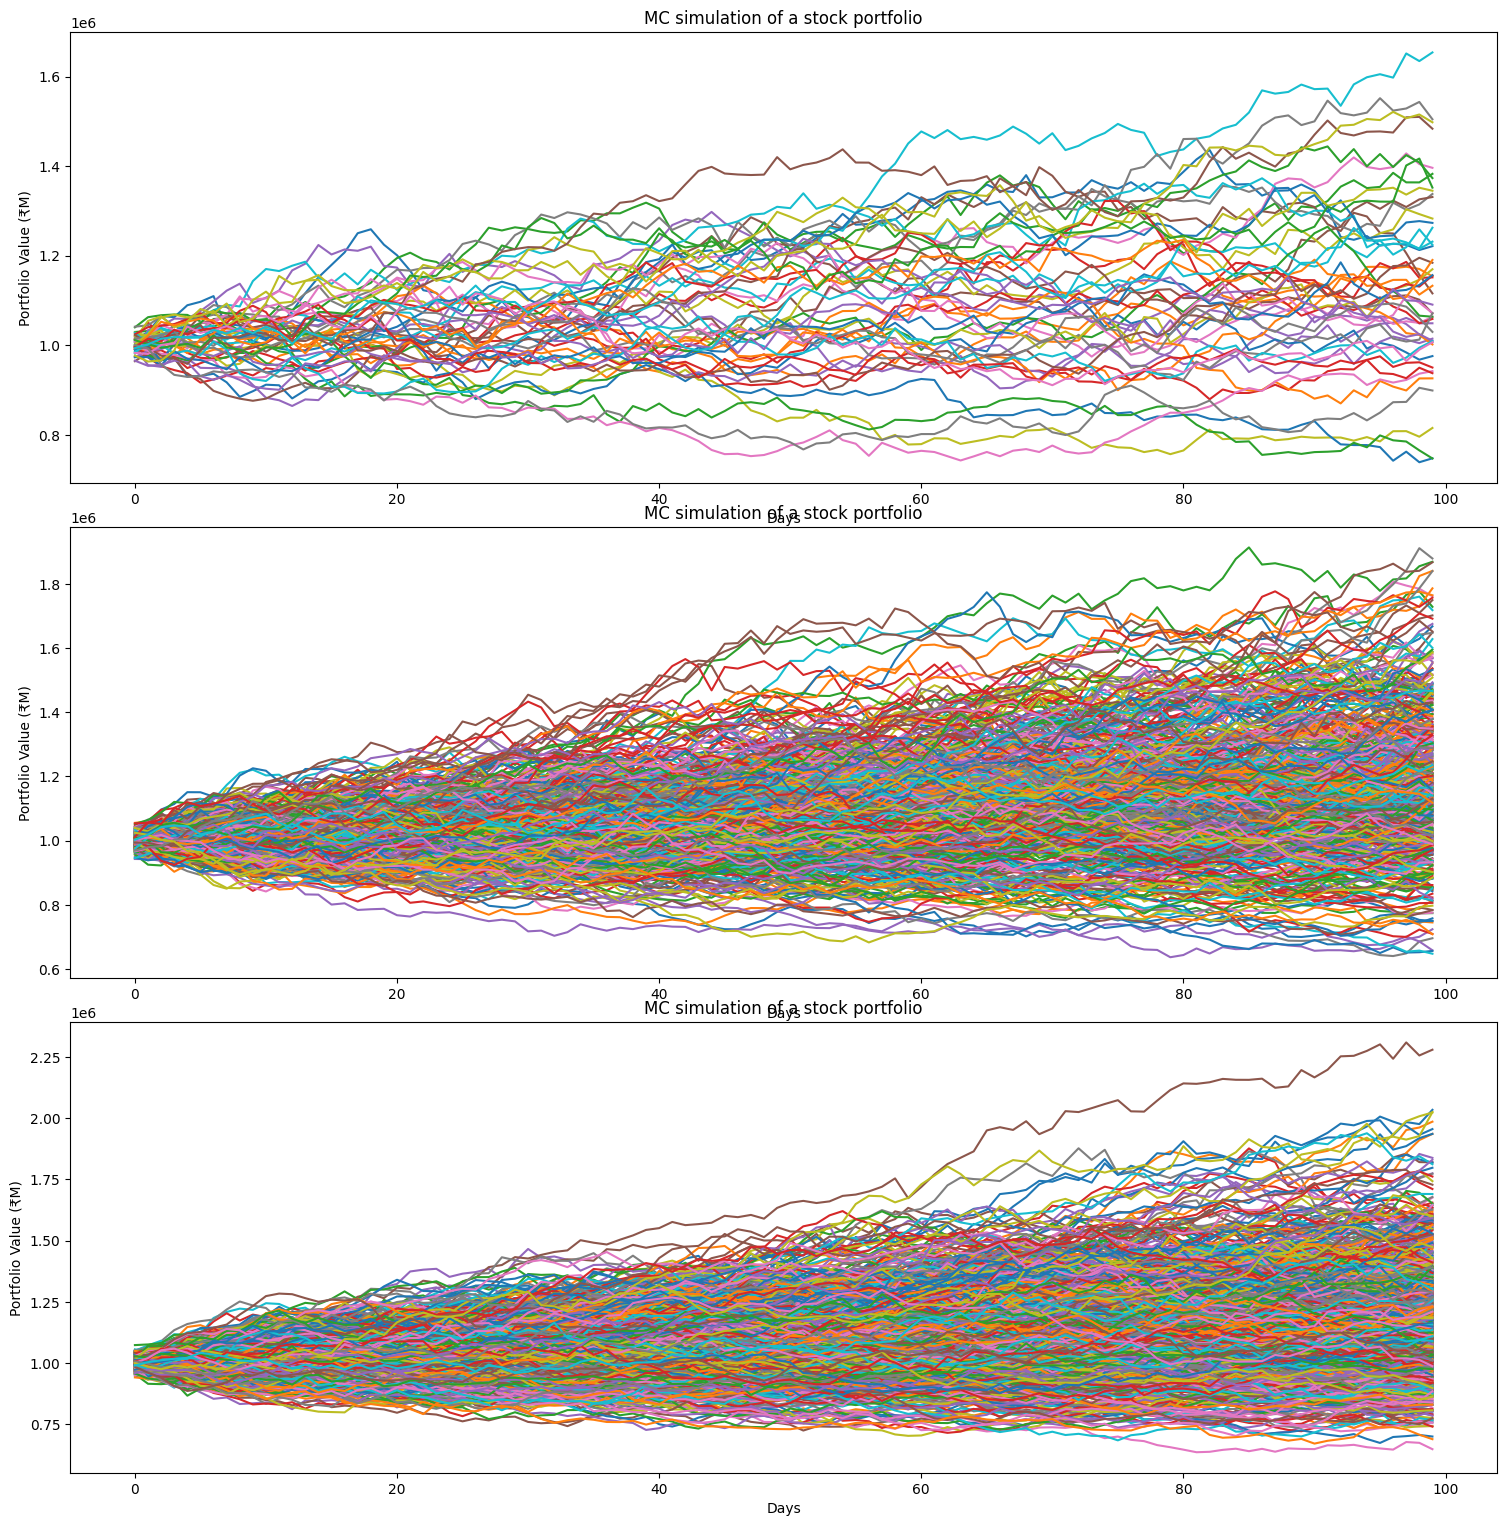

In [66]:

# Ploting portfolio simulation
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
fig.tight_layout()

for i, sim in enumerate(portfolio_b_simulations):
  # New subplot for each portfolio simulation
    plt.subplot(3, 1, i + 1,)

    plt.plot(sim)
    plt.ylabel('Portfolio Value (₹M)')
    plt.xlabel('Days')
    plt.title('MC simulation of a stock portfolio')

In [67]:

# Calculating portfolio VAR
for i, sim in enumerate(portfolio_b_simulations):
    portfolio_last_values = pd.Series(sim[-1,:])

    VaR = (config.INITIAL_PORTFOLIO - var_mcm(portfolio_last_values, alpha=5))

    print(f'95% VaR with {config.SIMULATIONS[i]} simulations: ₹{round(VaR,2)}')

95% VaR with 50 simulations: ₹147382.12
95% VaR with 500 simulations: ₹150870.03
95% VaR with 1000 simulations: ₹127708.49


Based on Monte Carlo simulations for calculating the 95% Value at Risk (VaR) for both portfolios, the results indicate that the hyped portfolio carries significantly higher risk. This is evident from the larger potential losses observed in the simulations, suggesting that investors could potentially lose more money compared to the diversified portfolio.